# Test several models

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

from sklearn.model_selection import GridSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [5]:
ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data('./data/weather_collections/weather_daily_region.csv')

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
# setting more years improves model predictions
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 


### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

In [6]:
#explore_clusters(gs_agg[['x', 'y']])

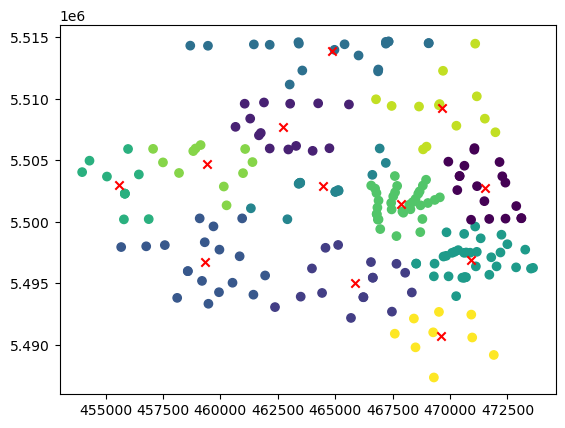

In [7]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

plot_clusters(gs_agg[['x', 'y']], labels, centers)

# Add clusters to stations
gs_agg['reg_clusters'] = labels
#gs_agg['reg_clusters'] = 0

### Merge data

In [8]:
g_merged = merge_groundwater_data(g, gs_agg)
#g_merged.describe()

In [9]:
#g_merged.head()

In [10]:
m = pd.merge(g_merged, w,
             how='left', left_index=True, right_index=True)

# restrict data to the post-war period
m = m.loc[m.date > pd.to_datetime('1950-01-01')]

# drop all rows with a date after the weather data cutoff date
m = m.loc[m.date <= pd.to_datetime('2022-12-31')]

m = m.dropna(subset=['station_id_count'])

m['week_of_year'] = m['date'].dt.isocalendar().week

In [11]:
#m.info()

In [12]:
#m.describe()

## Train-test split

In [13]:
m.columns.unique()

Index(['station_id', 'date', 'water_dist', 'water_level', 'water_depth',
       'water_temp', 'x', 'y', 'start_date', 'end_date', 'ground_elev',
       'measure_elev', 'lifespan', 'geometry', 'water_level_mean',
       'water_depth_mean', 'water_temp_mean', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'reg_clusters', 'water_depth_anomaly',
       'station_id_count', 'precip_mean', 'precip_min', 'precip_max',
       'precip_std', 'tmean_mean', 'tmean_min', 'tmean_max', 'tmean_std',
       'tmax_mean', 'tmax_min', 'tmax_max', 'tmax_std', 'tmin_mean',
       'tmin_min', 'tmin_max', 'tmin_std', 'moisture_mean', 'moisture_min',
       'moisture_max', 'moisture_std', 'precip_mean_prev_2d_sum',
       'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'precip_mean_prev_1y_sum',
       'precip_mean_prev_3y_sum', 'tmean_mean_prev_2d_mean',
       'tmean_mean_prev_7d_mean'

In [14]:
# restrict data to these columns
df = m[['station_id',
        'date',
        'water_depth',
        'ground_elev',
        'x', 'y',
        'geometry',
        'reg_clusters',
        'ini_years_water_depth_mean',
        'ini_years_water_depth_std',
        'ini_years_water_depth_min',
        'ini_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_2d_sum',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'precip_mean_prev_1y_sum',
        'precip_mean_prev_3y_sum',
        'tmean_mean_prev_2d_mean',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean',
        'tmean_mean_prev_1y_mean',
        'tmean_mean_prev_3y_mean'
       ]]
#df.info()

In [15]:
#df[df.isna().any(axis=1)]

In [16]:
df = df.dropna()

In [17]:
train, test, X_train, X_test, y_train, y_test, info_train, info_test = tt_split_by_stations(df)


## Exploratory hyperparameter search

### Define preprocessing steps

In [18]:
# select categorical and numerical column names
#X_cat_columns = X_train.select_dtypes(exclude="number").columns
X_cat_columns = X_train.select_dtypes(include="int32").columns
X_num_columns = X_train.select_dtypes(include="float64").columns

# create numerical pipeline
num_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='mean')), # probably not needed...
           #('num_scaler', MinMaxScaler())
           ('num_scaler', StandardScaler())
          ])

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = Pipeline(
    steps=[#('cat_imputer', SimpleImputer(strategy='constant', fill_value='na')),
            #('cat_imputer', SimpleImputer(strategy='constant', fill_value=0)), 
           ('cat_encoder', OneHotEncoder(drop='first', 
                                         sparse_output=False, 
                                         handle_unknown='ignore'))
           #('cat_encoder', OrdinalEncoder())
          ])

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, X_num_columns), 
        ('cat', categoric_pipe, X_cat_columns)
    ],
    #remainder='passthrough'
).set_output(transform='pandas')

In [20]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  StandardScaler())]),
                                 Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_2d_sum', 'precip_mean_prev_...
       'precip_mean_prev_1y_sum', 'precip_mean_prev_3y_sum',
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['reg_clusters'], dtype='object'))])

### Define regressors to test

In [21]:
regressors = [
    #('SGD', SGDRegressor()),
    ('LinReg', LinearRegression()),
    ('HGBoost', HistGradientBoostingRegressor()), # excellent and very fast
]

### Create a pipeline for each regressor

In [22]:
pipelines = {}
for name, reg in regressors:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('selector', SelectKBest(score_func=f_regression)),
        #('selector', RFECV(estimator=DecisionTreeRegressor())),
        #('feature_selection', SelectFromModel(DecisionTreeRegressor())),
        ('regressor', reg)
     ]).set_output(transform="pandas")
    pipelines[name] = pipeline


In [23]:
#pipelines['HGBoost']

### Define exploratory hyperparameters

In [24]:
param_grids_explore = {
    'SGD': {
        #'regressor__alpha': [0.00001, 0.001, 0.1], # d=0.0001
        'regressor__penalty': ['l1', 'l2', 'elasticnet'], # d='l2'
        #'regressor__learning_rate': ['optimal', 'invscaling' 'adaptive'], # d=invscaling
        #'regressor__max_iter': [100, 1000, 3000], # d=1000
        #'regressor__tol': [1e-3, 1e-4, 1e-5], # d=1e-3
        'regressor__loss': ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error'], # d=squared_error
        'regressor__early_stopping': [True, False], # d=False
        #'regressor__validation_fraction': [0.1, 0.2], # d=0.1
        'regressor__average': [True, False], # d=False
    },
    'LinReg': {
        # does not have tunable parameters
    },
    'HGBoost': {
        ##'regressor__learning_rate': [0.01, 0.1, 0.2], # d=0.1
        #'regressor__max_leaf_nodes': [5, 10, 30], # d=31
        #'regressor__max_depth': [None, 5, 10], # d=None
        #'regressor__min_samples_leaf': [5, 20, 50], # d=20
        #'regressor__l2_regularization': [0, 0.1], # d=0
        ##'regressor__max_bins': [255], # d=255
        ##'regressor__categorical_features': list(str('cat__' + X_cat_columns.values))
        #TODO: try to get categorical_features running...
    }
}


### Fit and evaluate models

In [25]:
# Fit and evaluate each pipeline
scores_explore = {}
params_explore = {}
estimator_explore = {}
predictions = {}
metrics = {}
residuals = {}

fit_models = True # for turning off costly exploratory fitting

for name in pipelines:
    print(f"\nTraining and evaluating {name}...")
    pipe = pipelines[name]
    grid_search = GridSearchCV(pipe, 
                               param_grids_explore[name], 
                               cv=5, 
                               #scoring='neg_mean_absolute_error',
                               #scoring='neg_mean_squared_error',
                               #scoring='r2',
                               verbose=2, n_jobs=-1)
    
    if fit_models == True:
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        #y_pred = grid_search.predict(X_test)
        #accuracy = accuracy_score(y_test, y_pred)
        
        print("Best parameters found:")
        print(grid_search.best_params_)
        #print("Classification report:")
        #print(classification_report(y_test, y_pred))
        #print(f"Accuracy: {accuracy:.4f}")
        
        scores_explore[name] = grid_search.best_score_
        params_explore[name] = grid_search.best_params_
        estimator_explore[name] = grid_search

        print('--- predict test data ---')
        y_pred = grid_search.predict(X_test)
        predictions[name] = y_pred
        metrics[name] = calc_metrics(y_test, y_pred)
        residuals[name] = calc_residuals(y_test, y_pred)


Training and evaluating LinReg...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{}
--- predict test data ---
MAE 0.6122237037791414
RMSE 0.8612518186222332
MAPE 160856305435.6229
R2 0.6065586251620245

Training and evaluating HGBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{}
--- predict test data ---
MAE 0.5235621281361029
RMSE 0.7265681297664774
MAPE 132251486047.71811
R2 0.7199907275927482


In [26]:
scores_explore

{'LinReg': 0.6868654710412405, 'HGBoost': 0.7139647555422195}

In [27]:
pd.DataFrame(params_explore)

,LinReg,HGBoost


In [28]:
estimator_explore['LinReg']

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('num_scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',...
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('cat_encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['reg_clusters'], dtype='object'))])),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1, param_grid={}, verbose=2)

In [29]:
compare_models = pd.DataFrame(metrics)
compare_models

,LinReg,HGBoost
MAE,6.122237e-01,5.235621e-01
RMSE,8.612518e-01,7.265681e-01
MAPE,1.608563e+11,1.322515e+11
R2,6.065586e-01,7.199907e-01


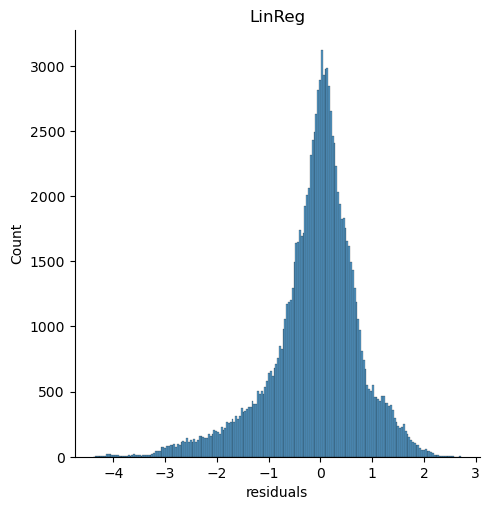

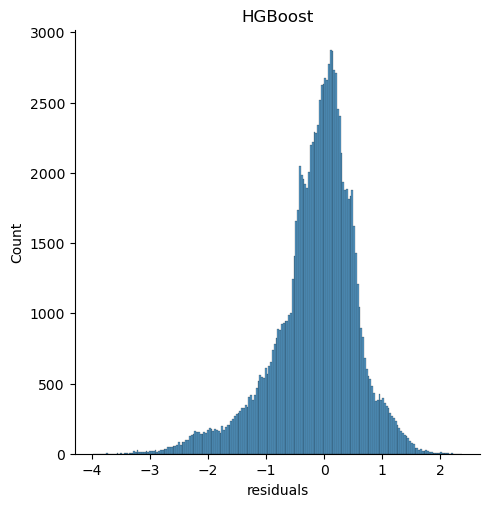

In [30]:
for name in residuals:
    #print(name)
    r = residuals[name]
    sns.displot(r['residuals']).set(title=name)

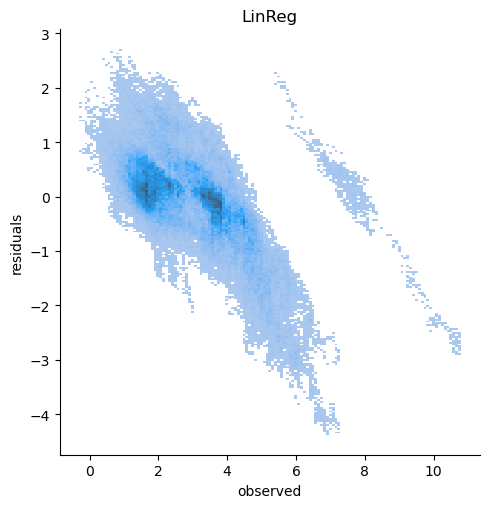

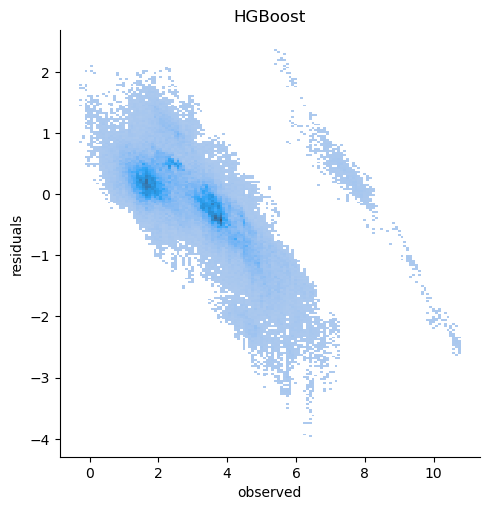

In [31]:
for name in residuals:
    r = residuals[name]
    #print(name, r.shape)
    sns.displot(data=r, x='observed', y='residuals').set(title=name)

### Analyse models

In [32]:
#model = 'LinReg'
model = 'HGBoost'
y_pred = predictions[model]
resid = residuals[model]

y_pred = pd.DataFrame(y_pred, columns=['pred_water_depth'])
y_pred.index = info_test.index
#y_pred

In [33]:
test = pd.concat([info_test, X_test, y_test, y_pred, resid['residuals']],
                 axis='columns')

In [34]:
#test.info()

In [35]:
#test.describe()

In [36]:
test.head()

,station_id,date,geometry,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,...,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean,water_depth,pred_water_depth,residuals
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,12942,1950-01-02,POINT (8.50101 49.70334),90.90,464019.133,5505766.787,1,2.107667,0.153382,1.75,...,1746.344286,-0.93750,2.825000,4.0775,6.524861,11.005240,10.748059,2.19,3.500345,1.310345
1950-01-03,13030,1950-01-03,POINT (8.52258 49.73732),90.82,465599.000,5509535.000,1,1.411469,0.406670,0.35,...,1747.431786,1.74375,2.092857,3.9350,6.404306,11.004897,10.756199,2.29,2.813991,0.523991
1950-01-04,13658,1950-01-04,POINT (8.50948 49.63252),93.14,464578.855,5497889.913,2,1.578772,0.284562,0.90,...,1752.794286,3.31250,1.503571,3.7950,6.294028,11.008493,10.768790,2.49,3.659570,1.169570
1950-01-04,13032,1950-01-04,POINT (8.50398 49.73805),90.92,464259.000,5509625.000,1,3.133808,0.341188,2.31,...,1752.794286,3.31250,1.503571,3.7950,6.294028,11.008493,10.768790,3.60,3.557391,-0.042609
1950-01-09,13658,1950-01-09,POINT (8.50948 49.63252),93.14,464578.855,5497889.913,2,1.578772,0.284562,0.90,...,1749.206786,0.97500,3.633929,3.3100,5.763333,11.041781,10.809623,2.49,3.607874,1.117874


In [37]:
test.station_id.unique()[0]

12942

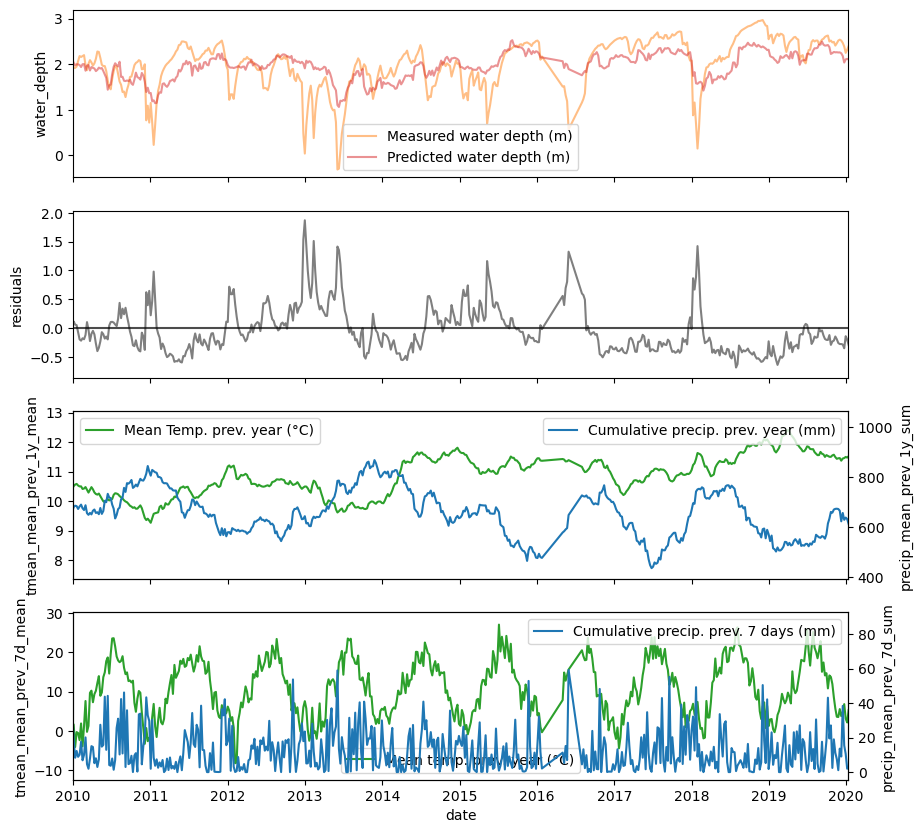

In [68]:
#data = train.loc[train.station_id == train.station_id.unique()[10]]
data = test.loc[test.station_id == test.station_id.unique()[10]]

plot_station_data(data#, pd.to_datetime('1950-01-01'), pd.to_datetime('1970-01-10')
                 , pd.to_datetime('2010-01-01'), pd.to_datetime('2020-01-10')
                 )

## Refinement hyperparameter search

### Define refinement hyperparameters

In [39]:
param_grids_refine = {
    'SGD': {
        #'regressor__alpha': [0.00001, 0.001, 0.1], # d=0.0001
        #'regressor__penalty': ['l1', 'l2', 'elasticnet'], # d='l2'
        #'regressor__learning_rate': ['optimal', 'invscaling' 'adaptive'], # d=invscaling
        #'regressor__max_iter': [100, 1000, 3000], # d=1000
        #'regressor__tol': [1e-3, 1e-4, 1e-5], # d=1e-3
        #'regressor__loss': ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error'], # d=squared_error
        #'regressor__early_stopping': [True, False], # d=False
        #'regressor__validation_fraction': [0.1, 0.2], # d=0.1
        #'regressor__average': [True, False], # d=False
    },
    'LinReg': {
        # does not have tunable parameters
    },
    'HGBoost': {
        ##'regressor__learning_rate': [0.01, 0.1, 0.2], # d=0.1
        #'regressor__max_leaf_nodes': [3, 5, 7], # d=31
        #'regressor__max_depth': [3, 5, 7], # d=None
        #'regressor__min_samples_leaf': [3, 5, 7], # d=20
        #'regressor__l2_regularization': [0, 0.05], # d=0
        ##'regressor__max_bins': [255], # d=255
        ##'regressor__categorical_features': list(str('cat__' + X_cat_columns.values))
        #TODO: try to get categorical_features running...
    }
}


### Fit and evaluate models

In [40]:
# Fit and evaluate each pipeline
scores_refine = {}
params_refine = {}
estimator_refine = {}
predictions = {}
metrics = {}
residuals = {}

fit_models = True # for turning off costly exploratory fitting

for name in pipelines:
    print(f"\nTraining and evaluating {name}...")
    pipe = pipelines[name]
    grid_search = GridSearchCV(pipe, 
                               param_grids_refine[name], 
                               cv=5, 
                               #scoring='neg_mean_absolute_error',
                               #scoring='neg_mean_squared_error',
                               #scoring='r2',
                               verbose=2, n_jobs=-1)
    
    if fit_models == True:
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        #y_pred = grid_search.predict(X_test)
        #accuracy = accuracy_score(y_test, y_pred)
        
        print("Best parameters found:")
        print(grid_search.best_params_)
        #print("Classification report:")
        #print(classification_report(y_test, y_pred))
        #print(f"Accuracy: {accuracy:.4f}")
        
        scores_refine[name] = grid_search.best_score_
        params_refine[name] = grid_search.best_params_
        estimator_refine[name] = grid_search

        print('--- predict test data ---')
        y_pred = grid_search.predict(X_test)
        predictions[name] = y_pred
        metrics[name] = calc_metrics(y_test, y_pred)
        residuals[name] = calc_residuals(y_test, y_pred)


Training and evaluating LinReg...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{}
--- predict test data ---
MAE 0.6122237037791414
RMSE 0.8612518186222332
MAPE 160856305435.6229
R2 0.6065586251620245

Training and evaluating HGBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{}
--- predict test data ---
MAE 0.5212160098891199
RMSE 0.7386067038400446
MAPE 130168793320.22235
R2 0.7106348565980797


In [41]:
scores_refine

{'LinReg': 0.6868654710412405, 'HGBoost': 0.7140045641372421}

In [42]:
pd.DataFrame(params_refine)

,LinReg,HGBoost


In [43]:
estimator_refine['LinReg']

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('num_scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',...
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('cat_encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['reg_clusters'], dtype='object'))])),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1, param_grid={}, verbose=2)

In [44]:
compare_models = pd.DataFrame(metrics)
compare_models

,LinReg,HGBoost
MAE,6.122237e-01,5.212160e-01
RMSE,8.612518e-01,7.386067e-01
MAPE,1.608563e+11,1.301688e+11
R2,6.065586e-01,7.106349e-01


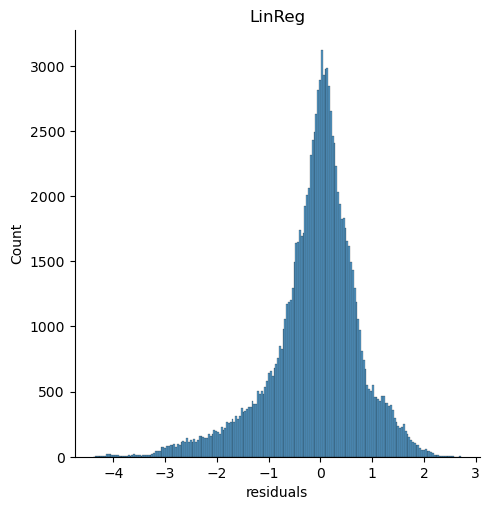

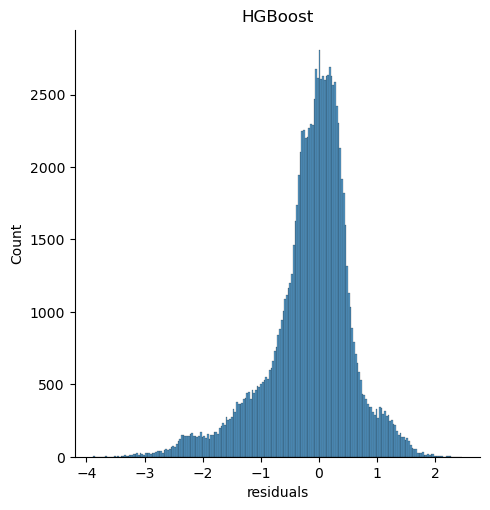

In [45]:
for name in residuals:
    #print(name)
    r = residuals[name]
    sns.displot(r['residuals']).set(title=name)

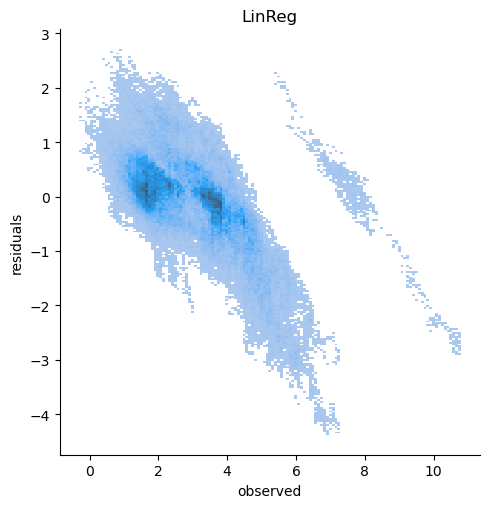

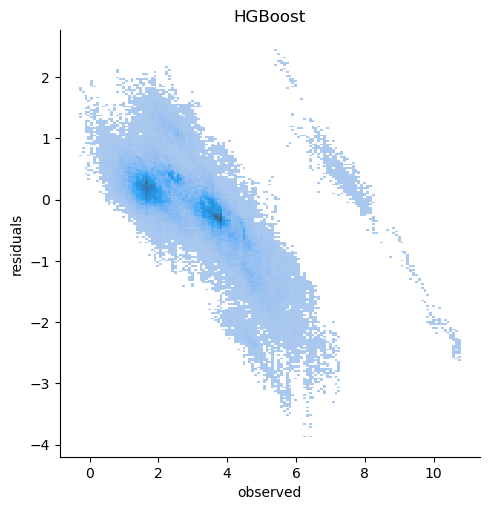

In [46]:
for name in residuals:
    r = residuals[name]
    #print(name, r.shape)
    sns.displot(data=r, x='observed', y='residuals').set(title=name)

### Analyse models

In [47]:
#model = 'LinReg'
model = 'HGBoost'

y_train_pred = estimator_refine[model].predict(X_train)
train_resid = calc_residuals(y_train, y_train_pred)

y_test_pred = estimator_refine[model].predict(X_test)
test_resid = calc_residuals(y_test, y_test_pred)

y_train_pred = pd.DataFrame(y_train_pred, columns=['pred_water_depth'])
y_train_pred.index = info_train.index

y_test_pred = pd.DataFrame(y_test_pred, columns=['pred_water_depth'])
y_test_pred.index = info_test.index
#y_pred

In [48]:
train = pd.concat([info_train, X_train, y_train, y_train_pred, train_resid['residuals']],
                 axis='columns')

test = pd.concat([info_test, X_test, y_test, y_test_pred, test_resid['residuals']],
                 axis='columns')

In [49]:
#train.info()

In [50]:
#test.info()

In [51]:
#train.describe()

In [52]:
#test.describe()

In [53]:
#train.head()

In [54]:
#test.head()

In [55]:
train.station_id.unique()[0]

13491

In [56]:
test.station_id.unique()[0]

12942

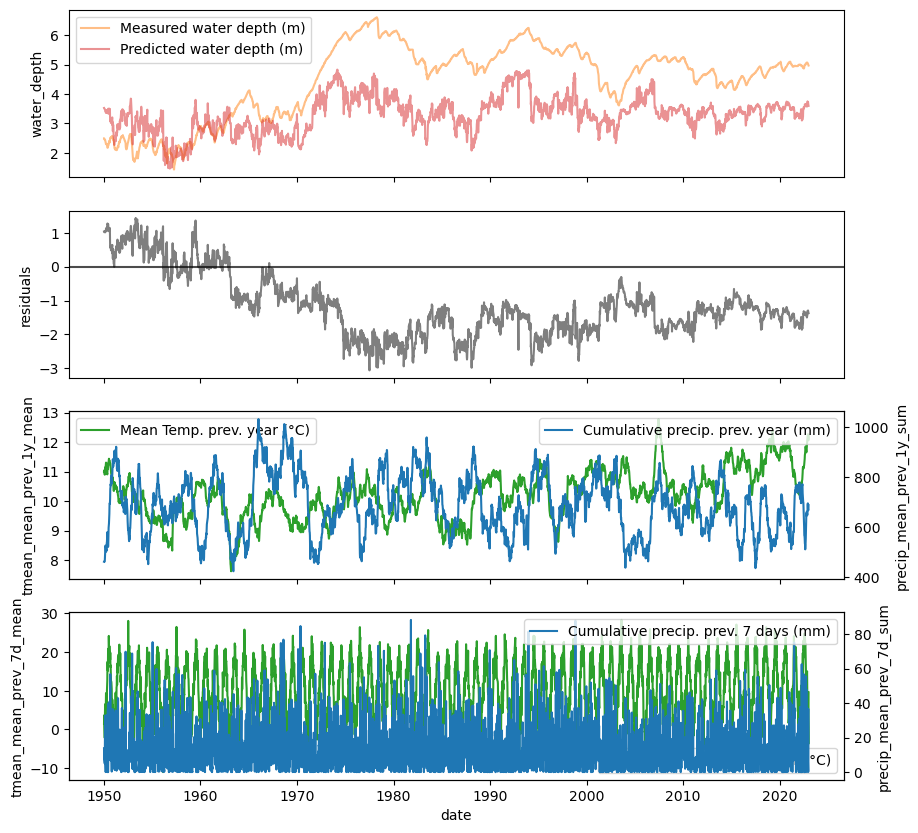

In [57]:
#data = train.loc[train.station_id == train.station_id.unique()[10]]
data = test.loc[test.station_id == test.station_id.unique()[2]]

plot_station_data(data)#, pd.to_datetime('1950-01-01'), pd.to_datetime('1970-01-10'))

## Analyze station variability

In [58]:
#df = train.copy()
df = test.copy()
geos = df[['station_id', 'geometry']]

#df.columns.unique()
geos.head()

,station_id,geometry
date,,
1950-01-02,12942,POINT (8.50101 49.70334)
1950-01-03,13030,POINT (8.52258 49.73732)
1950-01-04,13658,POINT (8.50948 49.63252)
1950-01-04,13032,POINT (8.50398 49.73805)
1950-01-09,13658,POINT (8.50948 49.63252)


In [59]:
stats = df[['station_id', #'geometry',
    'water_depth', 'pred_water_depth',
    'residuals']].groupby('station_id'
                          ).agg({'water_depth': ['mean', 'std', 'min', 'max'],
                                 'pred_water_depth': ['mean', 'std', 'min', 'max'],
                                 'residuals': ['mean', 'std', 'min', 'max']})

stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
stats = pd.merge(left=stats, right=geos, on='station_id', how='left')
stats.head()

,station_id,water_depth_mean,water_depth_std,water_depth_min,water_depth_max,pred_water_depth_mean,pred_water_depth_std,pred_water_depth_min,pred_water_depth_max,residuals_mean,residuals_std,residuals_min,residuals_max,geometry
0,12891,1.914308,0.645716,0.61,3.75,2.251825,0.454439,1.192458,3.706185,0.337516,0.399705,-1.175832,1.238741,POINT (8.48631 49.70426)
1,12891,1.914308,0.645716,0.61,3.75,2.251825,0.454439,1.192458,3.706185,0.337516,0.399705,-1.175832,1.238741,POINT (8.48631 49.70426)
2,12891,1.914308,0.645716,0.61,3.75,2.251825,0.454439,1.192458,3.706185,0.337516,0.399705,-1.175832,1.238741,POINT (8.48631 49.70426)
3,12891,1.914308,0.645716,0.61,3.75,2.251825,0.454439,1.192458,3.706185,0.337516,0.399705,-1.175832,1.238741,POINT (8.48631 49.70426)
4,12891,1.914308,0.645716,0.61,3.75,2.251825,0.454439,1.192458,3.706185,0.337516,0.399705,-1.175832,1.238741,POINT (8.48631 49.70426)


In [60]:
stats = gpd.GeoDataFrame(stats, geometry=stats['geometry'], crs='EPSG:4326')

In [61]:
stats.sort_values(by='residuals_mean').head()

,station_id,water_depth_mean,water_depth_std,water_depth_min,water_depth_max,pred_water_depth_mean,pred_water_depth_std,pred_water_depth_min,pred_water_depth_max,residuals_mean,residuals_std,residuals_min,residuals_max,geometry
35365,13159,4.19884,1.163303,1.76,6.47,2.453315,0.418986,1.288271,4.169277,-1.745524,0.967876,-3.882686,0.360391,POINT (8.59851 49.78203)
35098,13159,4.19884,1.163303,1.76,6.47,2.453315,0.418986,1.288271,4.169277,-1.745524,0.967876,-3.882686,0.360391,POINT (8.59851 49.78203)
35099,13159,4.19884,1.163303,1.76,6.47,2.453315,0.418986,1.288271,4.169277,-1.745524,0.967876,-3.882686,0.360391,POINT (8.59851 49.78203)
35100,13159,4.19884,1.163303,1.76,6.47,2.453315,0.418986,1.288271,4.169277,-1.745524,0.967876,-3.882686,0.360391,POINT (8.59851 49.78203)
35101,13159,4.19884,1.163303,1.76,6.47,2.453315,0.418986,1.288271,4.169277,-1.745524,0.967876,-3.882686,0.360391,POINT (8.59851 49.78203)


In [62]:
# Load hillshade DEM
dem, dem_extent = load_dem('./data/dem/bergstraße30_shaded.tif')

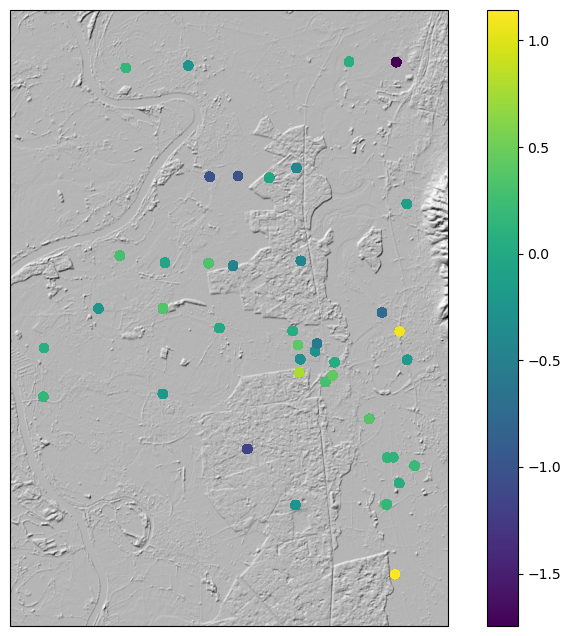

In [63]:
extent = stats.geometry.total_bounds

# Create a figure and axis with a PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()} # removes axis labels
                      )

# Plot hillshade DEM
ax.imshow(dem, extent=(dem_extent[0], dem_extent[2],
                       dem_extent[1], dem_extent[3]),
          cmap='gray', origin='upper', aspect='auto')

stats.plot(column='residuals_mean',
            #cmap='coolwarm',
            legend=True, 
            ax=ax)

ax.set_xlim(extent[0]-0.02, extent[2]+0.02)
ax.set_ylim(extent[1]-0.02, extent[3]+0.02)

#ax.legend(loc='lower left', framealpha=0.5)

#plt.title('Average water depth (m)')
#plt.savefig('./figs/map_mean_water_depth_all_stations.png', bbox_inches='tight')

# Show the plot
plt.show()

## TODO

first

- generalize hyperparameter exploration and model evaluation (especially for extremes)
- improve single station plotting routine

- implement location encoding by
    - discretizing x and y (pd.cut) and bucketing --> x-y grid
    - DONE performing clustering on the points with dbscan, kmean, knn, ...
- try to predict water_depth_anomaly?
- try with lag-shifted data...
- examine model accuracy (min/max/std of resids, ...) of each station

## Lessons learned

hyperparameters

- HGBoost works well, but is still not fast enough for grid search while input data is not yet optimized. is better than linreg for extreme events.
- first use linreg until all is good